In [ ]:
!pip install -q flwr["simulation"] tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 12.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model, Sequential
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
import keras
from keras.layers import Dense
import seaborn as sns
from google.colab import drive
from functools import partial
from sklearn.utils import shuffle

np.random.seed(42)



In [ ]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ddos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/DDoS_client_1.csv')
webbased = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/WebBased_client_2.csv')
# spoofing = pd.read_csv('/content/Spoofing_client_3.csv')
# recon = pd.read_csv('/content/Recon_client_4.csv')
dos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Dos_client_5.csv')

In [ ]:
print(f"ddos \n {ddos.shape}")
print(f"web based \n {webbased.shape}")
print(f"dos \n {dos.shape}")
# print(f"spoofing \n {spoofing.shape}")
# print(f"recon \n {recon.shape}") # I have taken the reconnaince out

ddos

ddos 
 (519478, 34)
web based 
 (34306, 34)
dos 
 (234299, 34)


,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,TCP,UDP,ARP,ICMP,IPv,LLC,Tot sum,Tot size,IAT,label
0,0.000000,54.00,6.00,64.00,18.961634,18.961634,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,8.334452e+07,1
1,0.000000,54.00,6.00,64.00,17.339716,17.339716,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,8.307208e+07,1
2,0.000000,54.00,6.00,64.00,37.503053,37.503053,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,8.333169e+07,1
3,0.000000,54.00,6.00,64.00,32.283211,32.283211,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,8.309439e+07,1
4,0.103837,34012.30,16.78,63.79,7069.744495,7069.744495,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,557.76,51.80,8.312387e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519473,0.070781,21825.00,17.00,64.00,6162.508840,6162.508840,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,525.00,50.00,8.310310e+07,1
519474,0.003539,12.05,1.25,63.23,39.502487,39.502487,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,9457.48,905.41,8.324982e+07,1
519475,0.831719,105.84,6.00,64.00,1.584386,1.584386,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.00,54.00,8.336248e+07,1
519476,0.001487,54.62,6.00,63.77,10.497196,10.497196,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,1.0,567.56,54.04,8.334916e+07,1


In [ ]:
file_paths = [
    '/content/drive/MyDrive/Colab Notebooks/datasets/DDoS_client_1.csv',
    '/content/drive/MyDrive/Colab Notebooks/datasets/WebBased_client_2.csv',
    # '/content/Spoofing_client_3.csv',
    # '/content/Recon_client_4.csv',
    '/content/drive/MyDrive/Colab Notebooks/datasets/Dos_client_5.csv'
]

from imblearn.over_sampling import SMOTE

global_X_train, global_y_train = [], []
global_X_, global_y_ = [], []

# Load datasets and split into global training and global test sets
for file_path in file_paths:
    df = pd.read_csv(file_path)

    df = shuffle(df).reset_index(drop=True)



    # Split the dataset into features (X) and target variable (y)
    # Assuming the last column is the target variable
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Split into global training and global test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)


    if '/content/drive/MyDrive/Colab Notebooks/datasets/Dos_client_5.csv' in file_path:
      # Assume X_train and y_train are your data
      sm = SMOTE(sampling_strategy={0: 210944}, random_state=42)
      X_res, y_res = sm.fit_resample(X_train, y_train)
      X_train = X_res
      y_train = y_res

    # Append the global training and global test sets to the respective lists
    global_X_train.append(X_train)
    global_y_train.append(y_train)

    global_X_.append(X_test)
    global_y_.append(y_test)


/usr/local/lib/python3.10/dist-packages/imblearn/utils/_validation.py:313: UserWarning: After over-sampling, the number of samples (210944) in class 0 will be larger than the number of samples in the majority class (class #1 -> 189805)
  warnings.warn(


In [ ]:
# Concatenate global test sets from each file
global_X_test = np.concatenate(global_X_)
global_y_test = np.concatenate(global_y_)

# Print the shape of concatenated global test sets
print("Global test X shape:", global_X_test.shape)
print("Global test y shape:", global_y_test.shape)

global_X_test

Global test X shape: (78809, 33)
Global test y shape: (78809,)


array([[-0.08841058, -0.07203763,  2.07750965, ..., -0.1829034 ,
        -0.19767222, -0.00729937],
       [-0.09902586, -0.12937802, -0.15122833, ..., -0.1866193 ,
        -0.19261828, -0.00847783],
       [-0.09902586, -0.12937123, -0.12894095, ..., -0.17324642,
        -0.18303486, -0.00999013],
       ...,
       [-0.03878092, -0.30881091, -0.6927967 , ..., -0.46591712,
        -0.48375835, -0.00617884],
       [ 0.31012373, -0.25075305, -0.6927967 , ...,  0.24307284,
        -0.30469238,  3.16257515],
       [ 0.86780388,  0.32507698, -0.58745979, ...,  0.66584016,
         1.06582666, -3.15091598]])

**Partitioning for the various local clients (Train, Test & Validation)**

In [ ]:
# Function to split the global training sets into train, validation, and test sets individually
def split_individual_train_sets(global_X_train, global_y_train, train_split=0.99):
    X_trains_split, y_trains_split = {}, {}
    X_vals_split, y_vals_split = {}, {}

    for idx, (X, y) in enumerate(zip(global_X_train,  global_y_train)):
        num_data = X.shape[0]
        train_end_idx = int(train_split * num_data)

        X_trains_split[str(idx)] = X[:train_end_idx]
        y_trains_split[str(idx)] = y[:train_end_idx]

        X_vals_split[str(idx)] = X[train_end_idx:]
        y_vals_split[str(idx)] = y[train_end_idx:]

    return X_trains_split, y_trains_split, X_vals_split, y_vals_split


# Print shapes of the combined datasets
print(f"Global test X shape: {global_X_test.shape}")
print(f"Global test y shape: {global_y_test.shape}")


Global test X shape: (78809, 33)
Global test y shape: (78809,)


In [ ]:
def get_model():
  model = Sequential()
  model.add(tf.keras.layers.Input(shape=(33,)),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(4, activation='relu'),)
  model.add(Dense(1, activation='sigmoid'),)
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss="binary_crossentropy", metrics=['accuracy'])
  return model

In [ ]:
VERBOSE = 0
NUM_CLIENTS = 3
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, model, X_train, y_train, X_val, y_val,):
        self.model = get_model()
        # self.model.build(self, input_shape=(None, 43))
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.X_train, self.y_train, epochs=5, batch_size=128, verbose=VERBOSE)
        return self.model.get_weights(), len(self.X_train), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, accuracy = self.model.evaluate(self.X_val, self.y_val)
        # Generate predictions
        # y_pred = self.model.predict(self.X_test,verbose=VERBOSE)
        # y_pred = (y_pred > 0.5)

        # Compute classification report
        # class_report = classification_report(self.y_test, y_pred, digits=5, zero_division=0)

        return loss, len(self.X_val), {"loss": loss, "accuracy": accuracy}


In [ ]:
## Defining the client function
def create_client(cid, X_trains, y_trains, X_vals, y_vals) -> fl.client.Client:
    """Create a Flower client representing a single organization."""
    model = get_model()  # Pass model_class as an argument

    return FlowerClient(model, X_trains[cid], y_trains[cid], X_vals[cid], y_vals[cid]).to_client()

X_trains_split, y_trains_split, X_vals_split, y_vals_split = split_individual_train_sets(global_X_train, global_y_train)

client_fnc = partial(
    create_client,
    # model_class=ANN,
    X_trains=X_trains_split,
    y_trains=y_trains_split,
    X_vals=X_vals_split,
    y_vals=y_vals_split,
)

In [ ]:
def weighted_average(metrics):
    total_samples = sum(num_samples for num_samples, _ in metrics)
    agg_loss = sum(num_samples * m.get("loss",0) for num_samples, m in metrics) / total_samples
    agg_accuracy = sum(num_samples * m.get("accuracy",1) for num_samples, m in metrics) / total_samples

    # Collect classification reports
    # classification_reports = [m.get("classification_report", "") for _, m in metrics]

    # Print each classification report with client number
    # for i, report in enumerate(classification_reports):
    #     print(f"Classification report for client {i+1}:\n{report}\n")

    return {"agg_loss": agg_loss, "agg_accuracy": agg_accuracy}

from typing import Dict, List, Tuple

def get_evaluate_fn(X_test, y_test):
    """Return an evaluation function for server-side (i.e. centralised) evaluation."""

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: fl.common.NDArrays,
        config: Dict[str, fl.common.Scalar],
    ):
        model = get_model()  # Construct the model
        # model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, accuracy = model.evaluate(X_test, y_test, verbose=VERBOSE)
        y_pred = model.predict(X_test)
        y_pred = (y_pred > 0.5)
        class_report = classification_report(y_test, y_pred, digits=5, zero_division=0)

        return loss, {"loss":loss, "accuracy": accuracy, "Centralised report": class_report}

    return evaluate

# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=1.0,  # Sample 100% of available clients for evaluation
    min_fit_clients=NUM_CLIENTS,  # Never sample less than the number of clients for training
    min_evaluate_clients=NUM_CLIENTS,  # Never sample less than the number of clients for evaluation
    min_available_clients=NUM_CLIENTS,  # Wait until all the number of clients are available
    evaluate_metrics_aggregation_fn=weighted_average, # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(global_X_test,global_y_test),## global evaluation function
)



In [ ]:
import time

start_time = time.time()

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=client_fnc,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=40),
    strategy=strategy,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    ray_init_args={
        "num_cpus": 1,
        "num_gpus": 0,
        "_system_config": {"automatic_object_spilling_enabled": False},
    },
)

end_time = time.time()
simulation_time = end_time - start_time

# Print the results
print("Training started at:", time.ctime(start_time))
print("Training finished at:", time.ctime(end_time))
print(f"Simulation time: {simulation_time:.2f} seconds")

INFO :      Starting Flower simulation, config: num_rounds=40, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=40, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-07 18:03:22,302	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 7692015207.0, 'object_store_memory': 3846007603.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7692015207.0, 'object_store_memory': 3846007603.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flow

2463/2463 [==============================] - 3s 1ms/step


INFO :      initial parameters (loss, other metrics): 0.5633272528648376, {'loss': 0.5633272528648376, 'accuracy': 0.9144006371498108, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.94815   0.07082   0.13179      7230\n           1    0.91417   0.99961   0.95498     71579\n\n    accuracy                        0.91440     78809\n   macro avg    0.93116   0.53521   0.54338     78809\nweighted avg    0.91729   0.91440   0.87946     78809\n'}
INFO:flwr:initial parameters (loss, other metrics): 0.5633272528648376, {'loss': 0.5633272528648376, 'accuracy': 0.9144006371498108, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.94815   0.07082   0.13179      7230\n           1    0.91417   0.99961   0.95498     71579\n\n    accuracy                        0.91440     78809\n   macro avg    0.93116   0.53521   0.54338     78809\nweighted avg    0.91729   0.91440   0.87946     78809\n'}
INFO :      

2463/2463 [==============================] - 3s 1ms/step


INFO :      fit progress: (1, 0.593224823474884, {'loss': 0.593224823474884, 'accuracy': 0.8792269825935364, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.38736   0.54412   0.45255      7230\n           1    0.95199   0.91308   0.93213     71579\n\n    accuracy                        0.87923     78809\n   macro avg    0.66967   0.72860   0.69234     78809\nweighted avg    0.90019   0.87923   0.88813     78809\n'}, 79.80394400500063)
INFO:flwr:fit progress: (1, 0.593224823474884, {'loss': 0.593224823474884, 'accuracy': 0.8792269825935364, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.38736   0.54412   0.45255      7230\n           1    0.95199   0.91308   0.93213     71579\n\n    accuracy                        0.87923     78809\n   macro avg    0.66967   0.72860   0.69234     78809\nweighted avg    0.90019   0.87923   0.88813     78809\n'}, 79.80394400500063)
INFO :      configure_ev

 79/147 [===============>..............] - ETA: 0s - loss: 0.4236 - accuracy: 0.8805


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.4494 - accuracy: 0.8728


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 3s 1ms/step


INFO :      fit progress: (2, 0.8698111176490784, {'loss': 0.8698111176490784, 'accuracy': 0.8697737455368042, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.33489   0.42545   0.37478      7230\n           1    0.94034   0.91465   0.92732     71579\n\n    accuracy                        0.86977     78809\n   macro avg    0.63762   0.67005   0.65105     78809\nweighted avg    0.88479   0.86977   0.87663     78809\n'}, 160.71613562600032)
INFO:flwr:fit progress: (2, 0.8698111176490784, {'loss': 0.8698111176490784, 'accuracy': 0.8697737455368042, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.33489   0.42545   0.37478      7230\n           1    0.94034   0.91465   0.92732     71579\n\n    accuracy                        0.86977     78809\n   macro avg    0.63762   0.67005   0.65105     78809\nweighted avg    0.88479   0.86977   0.87663     78809\n'}, 160.71613562600032)
INFO :      config

126/126 [==============================] - 0s 1ms/step - loss: 1.6741 - accuracy: 0.6350


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 10.6787 - accuracy: 0.1748


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 3s 1ms/step


INFO :      fit progress: (3, 0.9248741269111633, {'loss': 0.9248741269111633, 'accuracy': 0.8882741928100586, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42533   0.62047   0.50470      7230\n           1    0.95980   0.91532   0.93704     71579\n\n    accuracy                        0.88827     78809\n   macro avg    0.69257   0.76790   0.72087     78809\nweighted avg    0.91077   0.88827   0.89737     78809\n'}, 250.50570605600024)
INFO:flwr:fit progress: (3, 0.9248741269111633, {'loss': 0.9248741269111633, 'accuracy': 0.8882741928100586, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42533   0.62047   0.50470      7230\n           1    0.95980   0.91532   0.93704     71579\n\n    accuracy                        0.88827     78809\n   macro avg    0.69257   0.76790   0.72087     78809\nweighted avg    0.91077   0.88827   0.89737     78809\n'}, 250.50570605600024)
INFO :      config

147/147 [==============================] - 1s 3ms/step - loss: 0.4592 - accuracy: 0.8798


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 0.2459 - accuracy: 0.9676


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 3s 1ms/step


INFO :      fit progress: (4, 1.1406844854354858, {'loss': 1.1406844854354858, 'accuracy': 0.88299560546875, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40123   0.55934   0.46727      7230\n           1    0.95364   0.91569   0.93428     71579\n\n    accuracy                        0.88300     78809\n   macro avg    0.67744   0.73751   0.70078     78809\nweighted avg    0.90297   0.88300   0.89144     78809\n'}, 331.84245423300035)
INFO:flwr:fit progress: (4, 1.1406844854354858, {'loss': 1.1406844854354858, 'accuracy': 0.88299560546875, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40123   0.55934   0.46727      7230\n           1    0.95364   0.91569   0.93428     71579\n\n    accuracy                        0.88300     78809\n   macro avg    0.67744   0.73751   0.70078     78809\nweighted avg    0.90297   0.88300   0.89144     78809\n'}, 331.84245423300035)
INFO :      configure_

 47/126 [==========>...................] - ETA: 0s - loss: 0.1852 - accuracy: 0.9834


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 1s 2ms/step - loss: 0.2310 - accuracy: 0.9795


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (5, 1.1973904371261597, {'loss': 1.1973904371261597, 'accuracy': 0.8832747340202332, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40182   0.55726   0.46694      7230\n           1    0.95346   0.91620   0.93446     71579\n\n    accuracy                        0.88327     78809\n   macro avg    0.67764   0.73673   0.70070     78809\nweighted avg    0.90285   0.88327   0.89157     78809\n'}, 419.37203838799996)
INFO:flwr:fit progress: (5, 1.1973904371261597, {'loss': 1.1973904371261597, 'accuracy': 0.8832747340202332, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40182   0.55726   0.46694      7230\n           1    0.95346   0.91620   0.93446     71579\n\n    accuracy                        0.88327     78809\n   macro avg    0.67764   0.73673   0.70070     78809\nweighted avg    0.90285   0.88327   0.89157     78809\n'}, 419.37203838799996)
INFO :      config

147/147 [==============================] - 0s 1ms/step - loss: 0.2681 - accuracy: 0.8807


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


 78/126 [=================>............] - ETA: 0s - loss: 0.2531 - accuracy: 0.9828


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (6, 1.2157864570617676, {'loss': 1.2157864570617676, 'accuracy': 0.8825514912605286, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.39829   0.54869   0.46155      7230\n           1    0.95261   0.91627   0.93409     71579\n\n    accuracy                        0.88255     78809\n   macro avg    0.67545   0.73248   0.69782     78809\nweighted avg    0.90175   0.88255   0.89074     78809\n'}, 503.4430657510002)
INFO:flwr:fit progress: (6, 1.2157864570617676, {'loss': 1.2157864570617676, 'accuracy': 0.8825514912605286, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.39829   0.54869   0.46155      7230\n           1    0.95261   0.91627   0.93409     71579\n\n    accuracy                        0.88255     78809\n   macro avg    0.67545   0.73248   0.69782     78809\nweighted avg    0.90175   0.88255   0.89074     78809\n'}, 503.4430657510002)
INFO :      configur

147/147 [==============================] - 1s 3ms/step - loss: 0.1772 - accuracy: 0.8807


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 0.4836 - accuracy: 0.9805


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 6s 2ms/step


INFO :      fit progress: (7, 1.2410391569137573, {'loss': 1.2410391569137573, 'accuracy': 0.8831605315208435, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40173   0.55920   0.46756      7230\n           1    0.95364   0.91588   0.93438     71579\n\n    accuracy                        0.88316     78809\n   macro avg    0.67768   0.73754   0.70097     78809\nweighted avg    0.90301   0.88316   0.89155     78809\n'}, 595.0749961390002)
INFO:flwr:fit progress: (7, 1.2410391569137573, {'loss': 1.2410391569137573, 'accuracy': 0.8831605315208435, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40173   0.55920   0.46756      7230\n           1    0.95364   0.91588   0.93438     71579\n\n    accuracy                        0.88316     78809\n   macro avg    0.67768   0.73754   0.70097     78809\nweighted avg    0.90301   0.88316   0.89155     78809\n'}, 595.0749961390002)
INFO :      configur

126/126 [==============================] - 0s 2ms/step - loss: 0.5608 - accuracy: 0.9805


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 25.0947 - accuracy: 0.0841


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (8, 1.2876172065734863, {'loss': 1.2876172065734863, 'accuracy': 0.8847847580909729, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40930   0.57732   0.47900      7230\n           1    0.95546   0.91584   0.93523     71579\n\n    accuracy                        0.88478     78809\n   macro avg    0.68238   0.74658   0.70712     78809\nweighted avg    0.90535   0.88478   0.89338     78809\n'}, 678.880048039)
INFO:flwr:fit progress: (8, 1.2876172065734863, {'loss': 1.2876172065734863, 'accuracy': 0.8847847580909729, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40930   0.57732   0.47900      7230\n           1    0.95546   0.91584   0.93523     71579\n\n    accuracy                        0.88478     78809\n   macro avg    0.68238   0.74658   0.70712     78809\nweighted avg    0.90535   0.88478   0.89338     78809\n'}, 678.880048039)
INFO :      configure_evalua

114/147 [======================>.......] - ETA: 0s - loss: 0.2210 - accuracy: 0.8808


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 0.6120 - accuracy: 0.9803


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (9, 1.3448415994644165, {'loss': 1.3448415994644165, 'accuracy': 0.8877792954444885, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.41932   0.58008   0.48677      7230\n           1    0.95588   0.91886   0.93700     71579\n\n    accuracy                        0.88778     78809\n   macro avg    0.68760   0.74947   0.71189     78809\nweighted avg    0.90665   0.88778   0.89570     78809\n'}, 763.8648836770008)
INFO:flwr:fit progress: (9, 1.3448415994644165, {'loss': 1.3448415994644165, 'accuracy': 0.8877792954444885, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.41932   0.58008   0.48677      7230\n           1    0.95588   0.91886   0.93700     71579\n\n    accuracy                        0.88778     78809\n   macro avg    0.68760   0.74947   0.71189     78809\nweighted avg    0.90665   0.88778   0.89570     78809\n'}, 763.8648836770008)
INFO :      configur

 63/147 [===========>..................] - ETA: 0s - loss: 0.1802 - accuracy: 0.8859


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 1s 2ms/step - loss: 0.1816 - accuracy: 0.8849


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (10, 1.377259373664856, {'loss': 1.377259373664856, 'accuracy': 0.8845182657241821, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40784   0.57261   0.47638      7230\n           1    0.95499   0.91602   0.93510     71579\n\n    accuracy                        0.88452     78809\n   macro avg    0.68142   0.74432   0.70574     78809\nweighted avg    0.90480   0.88452   0.89302     78809\n'}, 854.0028185300007)
INFO:flwr:fit progress: (10, 1.377259373664856, {'loss': 1.377259373664856, 'accuracy': 0.8845182657241821, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.40784   0.57261   0.47638      7230\n           1    0.95499   0.91602   0.93510     71579\n\n    accuracy                        0.88452     78809\n   macro avg    0.68142   0.74432   0.70574     78809\nweighted avg    0.90480   0.88452   0.89302     78809\n'}, 854.0028185300007)
INFO :      configure_

 73/126 [================>.............] - ETA: 0s - loss: 0.6688 - accuracy: 0.9824


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


121/126 [===========================>..] - ETA: 0s - loss: 0.7333 - accuracy: 0.9811


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (11, 1.3616935014724731, {'loss': 1.3616935014724731, 'accuracy': 0.885469913482666, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.41230   0.58396   0.48334      7230\n           1    0.95613   0.91593   0.93560     71579\n\n    accuracy                        0.88547     78809\n   macro avg    0.68422   0.74994   0.70947     78809\nweighted avg    0.90624   0.88547   0.89411     78809\n'}, 937.0436825430006)
INFO:flwr:fit progress: (11, 1.3616935014724731, {'loss': 1.3616935014724731, 'accuracy': 0.885469913482666, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.41230   0.58396   0.48334      7230\n           1    0.95613   0.91593   0.93560     71579\n\n    accuracy                        0.88547     78809\n   macro avg    0.68422   0.74994   0.70947     78809\nweighted avg    0.90624   0.88547   0.89411     78809\n'}, 937.0436825430006)
INFO :      configur

147/147 [==============================] - 1s 2ms/step - loss: 0.1654 - accuracy: 0.8807


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 3ms/step - loss: 27.9238 - accuracy: 0.1359


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (12, 1.5094852447509766, {'loss': 1.5094852447509766, 'accuracy': 0.8889467120170593, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42137   0.56404   0.48238      7230\n           1    0.95441   0.92176   0.93780     71579\n\n    accuracy                        0.88895     78809\n   macro avg    0.68789   0.74290   0.71009     78809\nweighted avg    0.90550   0.88895   0.89602     78809\n'}, 1028.7599831900006)
INFO:flwr:fit progress: (12, 1.5094852447509766, {'loss': 1.5094852447509766, 'accuracy': 0.8889467120170593, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42137   0.56404   0.48238      7230\n           1    0.95441   0.92176   0.93780     71579\n\n    accuracy                        0.88895     78809\n   macro avg    0.68789   0.74290   0.71009     78809\nweighted avg    0.90550   0.88895   0.89602     78809\n'}, 1028.7599831900006)
INFO :      conf

10/10 [==============================] - 0s 2ms/step - loss: 31.3427 - accuracy: 0.0874


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 0.8828 - accuracy: 0.9758


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (13, 1.6048648357391357, {'loss': 1.6048648357391357, 'accuracy': 0.8889340162277222, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42361   0.58409   0.49108      7230\n           1    0.95632   0.91973   0.93767     71579\n\n    accuracy                        0.88893     78809\n   macro avg    0.68997   0.75191   0.71437     78809\nweighted avg    0.90745   0.88893   0.89669     78809\n'}, 1113.9209665930002)
INFO:flwr:fit progress: (13, 1.6048648357391357, {'loss': 1.6048648357391357, 'accuracy': 0.8889340162277222, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.42361   0.58409   0.49108      7230\n           1    0.95632   0.91973   0.93767     71579\n\n    accuracy                        0.88893     78809\n   macro avg    0.68997   0.75191   0.71437     78809\nweighted avg    0.90745   0.88893   0.89669     78809\n'}, 1113.9209665930002)
INFO :      conf

139/147 [===========================>..] - ETA: 0s - loss: 0.1307 - accuracy: 0.8862


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 0.9058 - accuracy: 0.9785


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (14, 1.6292552947998047, {'loss': 1.6292552947998047, 'accuracy': 0.891471803188324, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.43299   0.59115   0.49985      7230\n           1    0.95712   0.92181   0.93913     71579\n\n    accuracy                        0.89147     78809\n   macro avg    0.69505   0.75648   0.71949     78809\nweighted avg    0.90904   0.89147   0.89883     78809\n'}, 1202.6880980000005)
INFO:flwr:fit progress: (14, 1.6292552947998047, {'loss': 1.6292552947998047, 'accuracy': 0.891471803188324, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.43299   0.59115   0.49985      7230\n           1    0.95712   0.92181   0.93913     71579\n\n    accuracy                        0.89147     78809\n   macro avg    0.69505   0.75648   0.71949     78809\nweighted avg    0.90904   0.89147   0.89883     78809\n'}, 1202.6880980000005)
INFO :      config

 72/147 [=============>................] - ETA: 0s - loss: 0.1010 - accuracy: 0.8937


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 1s 2ms/step - loss: 0.1060 - accuracy: 0.8909


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (15, 1.6762031316757202, {'loss': 1.6762031316757202, 'accuracy': 0.9556015133857727, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.90300   0.57815   0.70495      7230\n           1    0.95888   0.99373   0.97599     71579\n\n    accuracy                        0.95560     78809\n   macro avg    0.93094   0.78594   0.84047     78809\nweighted avg    0.95376   0.95560   0.95113     78809\n'}, 1294.7739133320001)
INFO:flwr:fit progress: (15, 1.6762031316757202, {'loss': 1.6762031316757202, 'accuracy': 0.9556015133857727, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.90300   0.57815   0.70495      7230\n           1    0.95888   0.99373   0.97599     71579\n\n    accuracy                        0.95560     78809\n   macro avg    0.93094   0.78594   0.84047     78809\nweighted avg    0.95376   0.95560   0.95113     78809\n'}, 1294.7739133320001)
INFO :      conf

10/10 [==============================] - 0s 2ms/step - loss: 36.4198 - accuracy: 0.1100


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 16]
INFO:flwr:[ROUND 16]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.0432 - accuracy: 0.9889


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 3s 1ms/step


INFO :      fit progress: (16, 1.7921123504638672, {'loss': 1.7921123504638672, 'accuracy': 0.9610831141471863, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98038   0.58755   0.73476      7230\n           1    0.95996   0.99881   0.97900     71579\n\n    accuracy                        0.96108     78809\n   macro avg    0.97017   0.79318   0.85688     78809\nweighted avg    0.96183   0.96108   0.95659     78809\n'}, 1380.1213361990003)
INFO:flwr:fit progress: (16, 1.7921123504638672, {'loss': 1.7921123504638672, 'accuracy': 0.9610831141471863, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98038   0.58755   0.73476      7230\n           1    0.95996   0.99881   0.97900     71579\n\n    accuracy                        0.96108     78809\n   macro avg    0.97017   0.79318   0.85688     78809\nweighted avg    0.96183   0.96108   0.95659     78809\n'}, 1380.1213361990003)
INFO :      conf

117/147 [======================>.......] - ETA: 0s - loss: 0.0241 - accuracy: 0.9979


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 17]
INFO:flwr:[ROUND 17]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 1.0055 - accuracy: 0.9798


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (17, 1.8987363576889038, {'loss': 1.8987363576889038, 'accuracy': 0.9590402245521545, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98615   0.56141   0.71549      7230\n           1    0.95755   0.99920   0.97793     71579\n\n    accuracy                        0.95904     78809\n   macro avg    0.97185   0.78031   0.84671     78809\nweighted avg    0.96017   0.95904   0.95386     78809\n'}, 1474.9770314950001)
INFO:flwr:fit progress: (17, 1.8987363576889038, {'loss': 1.8987363576889038, 'accuracy': 0.9590402245521545, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98615   0.56141   0.71549      7230\n           1    0.95755   0.99920   0.97793     71579\n\n    accuracy                        0.95904     78809\n   macro avg    0.97185   0.78031   0.84671     78809\nweighted avg    0.96017   0.95904   0.95386     78809\n'}, 1474.9770314950001)
INFO :      conf

115/126 [==========================>...] - ETA: 0s - loss: 1.0421 - accuracy: 0.9807


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 18]
INFO:flwr:[ROUND 18]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 41.5765 - accuracy: 0.0712


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (18, 1.9275610446929932, {'loss': 1.9275610446929932, 'accuracy': 0.9605374932289124, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98931   0.57607   0.72815      7230\n           1    0.95891   0.99937   0.97872     71579\n\n    accuracy                        0.96054     78809\n   macro avg    0.97411   0.78772   0.85344     78809\nweighted avg    0.96170   0.96054   0.95574     78809\n'}, 1562.684442144)
INFO:flwr:fit progress: (18, 1.9275610446929932, {'loss': 1.9275610446929932, 'accuracy': 0.9605374932289124, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98931   0.57607   0.72815      7230\n           1    0.95891   0.99937   0.97872     71579\n\n    accuracy                        0.96054     78809\n   macro avg    0.97411   0.78772   0.85344     78809\nweighted avg    0.96170   0.96054   0.95574     78809\n'}, 1562.684442144)
INFO :      configure_ev

 49/126 [==========>...................] - ETA: 0s - loss: 0.7593 - accuracy: 0.9847


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 19]
INFO:flwr:[ROUND 19]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 1s 2ms/step - loss: 0.9993 - accuracy: 0.9798


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (19, 1.927960753440857, {'loss': 1.927960753440857, 'accuracy': 0.9597000479698181, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99009   0.56639   0.72057      7230\n           1    0.95802   0.99943   0.97828     71579\n\n    accuracy                        0.95970     78809\n   macro avg    0.97405   0.78291   0.84943     78809\nweighted avg    0.96096   0.95970   0.95464     78809\n'}, 1648.2382542610003)
INFO:flwr:fit progress: (19, 1.927960753440857, {'loss': 1.927960753440857, 'accuracy': 0.9597000479698181, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99009   0.56639   0.72057      7230\n           1    0.95802   0.99943   0.97828     71579\n\n    accuracy                        0.95970     78809\n   macro avg    0.97405   0.78291   0.84943     78809\nweighted avg    0.96096   0.95970   0.95464     78809\n'}, 1648.2382542610003)
INFO :      configur

106/147 [====================>.........] - ETA: 0s - loss: 0.0040 - accuracy: 0.9997


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 20]
INFO:flwr:[ROUND 20]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 1.0490 - accuracy: 0.9793


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (20, 1.8559390306472778, {'loss': 1.8559390306472778, 'accuracy': 0.9611465930938721, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99035   0.58216   0.73328      7230\n           1    0.95948   0.99943   0.97905     71579\n\n    accuracy                        0.96115     78809\n   macro avg    0.97492   0.79079   0.85616     78809\nweighted avg    0.96231   0.96115   0.95650     78809\n'}, 1741.650151289)
INFO:flwr:fit progress: (20, 1.8559390306472778, {'loss': 1.8559390306472778, 'accuracy': 0.9611465930938721, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99035   0.58216   0.73328      7230\n           1    0.95948   0.99943   0.97905     71579\n\n    accuracy                        0.96115     78809\n   macro avg    0.97492   0.79079   0.85616     78809\nweighted avg    0.96231   0.96115   0.95650     78809\n'}, 1741.650151289)
INFO :      configure_ev

147/147 [==============================] - 0s 2ms/step - loss: 0.0081 - accuracy: 0.9991


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 21]
INFO:flwr:[ROUND 21]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 40.6105 - accuracy: 0.1133


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (21, 1.9612752199172974, {'loss': 1.9612752199172974, 'accuracy': 0.9618317484855652, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99207   0.58866   0.73889      7230\n           1    0.96009   0.99953   0.97941     71579\n\n    accuracy                        0.96183     78809\n   macro avg    0.97608   0.79409   0.85915     78809\nweighted avg    0.96302   0.96183   0.95735     78809\n'}, 1830.044170219)
INFO:flwr:fit progress: (21, 1.9612752199172974, {'loss': 1.9612752199172974, 'accuracy': 0.9618317484855652, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99207   0.58866   0.73889      7230\n           1    0.96009   0.99953   0.97941     71579\n\n    accuracy                        0.96183     78809\n   macro avg    0.97608   0.79409   0.85915     78809\nweighted avg    0.96302   0.96183   0.95735     78809\n'}, 1830.044170219)
INFO :      configure_ev

126/126 [==============================] - 1s 2ms/step - loss: 1.0430 - accuracy: 0.9795


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 22]
INFO:flwr:[ROUND 22]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 4ms/step - loss: 42.8219 - accuracy: 0.1262


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (22, 1.9139714241027832, {'loss': 1.9139714241027832, 'accuracy': 0.960994303226471, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99288   0.57898   0.73143      7230\n           1    0.95919   0.99958   0.97897     71579\n\n    accuracy                        0.96099     78809\n   macro avg    0.97604   0.78928   0.85520     78809\nweighted avg    0.96228   0.96099   0.95626     78809\n'}, 1915.9919919740005)
INFO:flwr:fit progress: (22, 1.9139714241027832, {'loss': 1.9139714241027832, 'accuracy': 0.960994303226471, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99288   0.57898   0.73143      7230\n           1    0.95919   0.99958   0.97897     71579\n\n    accuracy                        0.96099     78809\n   macro avg    0.97604   0.78928   0.85520     78809\nweighted avg    0.96228   0.96099   0.95626     78809\n'}, 1915.9919919740005)
INFO :      config

116/126 [==========================>...] - ETA: 0s - loss: 1.0532 - accuracy: 0.9801


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 23]
INFO:flwr:[ROUND 23]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 41.7390 - accuracy: 0.1068


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (23, 2.0630550384521484, {'loss': 2.0630550384521484, 'accuracy': 0.9589514136314392, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99236   0.55685   0.71339      7230\n           1    0.95714   0.99957   0.97789     71579\n\n    accuracy                        0.95895     78809\n   macro avg    0.97475   0.77821   0.84564     78809\nweighted avg    0.96037   0.95895   0.95363     78809\n'}, 2006.906376498)
INFO:flwr:fit progress: (23, 2.0630550384521484, {'loss': 2.0630550384521484, 'accuracy': 0.9589514136314392, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99236   0.55685   0.71339      7230\n           1    0.95714   0.99957   0.97789     71579\n\n    accuracy                        0.95895     78809\n   macro avg    0.97475   0.77821   0.84564     78809\nweighted avg    0.96037   0.95895   0.95363     78809\n'}, 2006.906376498)
INFO :      configure_ev

10/10 [==============================] - 0s 2ms/step - loss: 45.1744 - accuracy: 0.0615


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 24]
INFO:flwr:[ROUND 24]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.0046 - accuracy: 0.9996


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (24, 2.05899715423584, {'loss': 2.05899715423584, 'accuracy': 0.9587610363960266, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98822   0.55712   0.71254      7230\n           1    0.95715   0.99933   0.97779     71579\n\n    accuracy                        0.95876     78809\n   macro avg    0.97269   0.77823   0.84516     78809\nweighted avg    0.96000   0.95876   0.95345     78809\n'}, 2091.9235085220007)
INFO:flwr:fit progress: (24, 2.05899715423584, {'loss': 2.05899715423584, 'accuracy': 0.9587610363960266, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.98822   0.55712   0.71254      7230\n           1    0.95715   0.99933   0.97779     71579\n\n    accuracy                        0.95876     78809\n   macro avg    0.97269   0.77823   0.84516     78809\nweighted avg    0.96000   0.95876   0.95345     78809\n'}, 2091.9235085220007)
INFO :      configure_ev

 69/147 [=============>................] - ETA: 0s - loss: 0.0048 - accuracy: 0.9995


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 25]
INFO:flwr:[ROUND 25]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 3ms/step - loss: 45.0969 - accuracy: 0.0615


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (25, 2.0931499004364014, {'loss': 2.0931499004364014, 'accuracy': 0.9592432379722595, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99532   0.55837   0.71540      7230\n           1    0.95729   0.99973   0.97805     71579\n\n    accuracy                        0.95924     78809\n   macro avg    0.97630   0.77905   0.84672     78809\nweighted avg    0.96077   0.95924   0.95395     78809\n'}, 2183.3881652570008)
INFO:flwr:fit progress: (25, 2.0931499004364014, {'loss': 2.0931499004364014, 'accuracy': 0.9592432379722595, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99532   0.55837   0.71540      7230\n           1    0.95729   0.99973   0.97805     71579\n\n    accuracy                        0.95924     78809\n   macro avg    0.97630   0.77905   0.84672     78809\nweighted avg    0.96077   0.95924   0.95395     78809\n'}, 2183.3881652570008)
INFO :      conf

126/126 [==============================] - 0s 1ms/step - loss: 1.1390 - accuracy: 0.9790


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 26]
INFO:flwr:[ROUND 26]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 45.6580 - accuracy: 0.0615


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 6s 2ms/step


INFO :      fit progress: (26, 2.107858419418335, {'loss': 2.107858419418335, 'accuracy': 0.9604232907295227, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99590   0.57095   0.72580      7230\n           1    0.95845   0.99976   0.97867     71579\n\n    accuracy                        0.96042     78809\n   macro avg    0.97718   0.78536   0.85224     78809\nweighted avg    0.96189   0.96042   0.95547     78809\n'}, 2270.2306692780003)
INFO:flwr:fit progress: (26, 2.107858419418335, {'loss': 2.107858419418335, 'accuracy': 0.9604232907295227, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99590   0.57095   0.72580      7230\n           1    0.95845   0.99976   0.97867     71579\n\n    accuracy                        0.96042     78809\n   macro avg    0.97718   0.78536   0.85224     78809\nweighted avg    0.96189   0.96042   0.95547     78809\n'}, 2270.2306692780003)
INFO :      configur

147/147 [==============================] - 0s 1ms/step - loss: 0.0038 - accuracy: 0.9996


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 27]
INFO:flwr:[ROUND 27]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 1.1667 - accuracy: 0.9743


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (27, 2.0857748985290527, {'loss': 2.0857748985290527, 'accuracy': 0.9613242149353027, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99573   0.58091   0.73375      7230\n           1    0.95938   0.99975   0.97915     71579\n\n    accuracy                        0.96132     78809\n   macro avg    0.97756   0.79033   0.85645     78809\nweighted avg    0.96271   0.96132   0.95663     78809\n'}, 2358.7912963440003)
INFO:flwr:fit progress: (27, 2.0857748985290527, {'loss': 2.0857748985290527, 'accuracy': 0.9613242149353027, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99573   0.58091   0.73375      7230\n           1    0.95938   0.99975   0.97915     71579\n\n    accuracy                        0.96132     78809\n   macro avg    0.97756   0.79033   0.85645     78809\nweighted avg    0.96271   0.96132   0.95663     78809\n'}, 2358.7912963440003)
INFO :      conf

126/126 [==============================] - 0s 2ms/step - loss: 1.2528 - accuracy: 0.9800


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 28]
INFO:flwr:[ROUND 28]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 0.9996


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (28, 2.174936294555664, {'loss': 2.174936294555664, 'accuracy': 0.9608293175697327, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99522   0.57580   0.72952      7230\n           1    0.95890   0.99972   0.97889     71579\n\n    accuracy                        0.96083     78809\n   macro avg    0.97706   0.78776   0.85420     78809\nweighted avg    0.96223   0.96083   0.95601     78809\n'}, 2448.745764798)
INFO:flwr:fit progress: (28, 2.174936294555664, {'loss': 2.174936294555664, 'accuracy': 0.9608293175697327, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99522   0.57580   0.72952      7230\n           1    0.95890   0.99972   0.97889     71579\n\n    accuracy                        0.96083     78809\n   macro avg    0.97706   0.78776   0.85420     78809\nweighted avg    0.96223   0.96083   0.95601     78809\n'}, 2448.745764798)
INFO :      configure_evalua

147/147 [==============================] - 0s 1ms/step - loss: 0.0048 - accuracy: 0.9996


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 29]
INFO:flwr:[ROUND 29]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 3ms/step - loss: 47.4609 - accuracy: 0.1100


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (29, 2.19726824760437, {'loss': 2.19726824760437, 'accuracy': 0.9602075815200806, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99564   0.56874   0.72394      7230\n           1    0.95825   0.99975   0.97856     71579\n\n    accuracy                        0.96021     78809\n   macro avg    0.97694   0.78424   0.85125     78809\nweighted avg    0.96168   0.96021   0.95520     78809\n'}, 2539.872717735)
INFO:flwr:fit progress: (29, 2.19726824760437, {'loss': 2.19726824760437, 'accuracy': 0.9602075815200806, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99564   0.56874   0.72394      7230\n           1    0.95825   0.99975   0.97856     71579\n\n    accuracy                        0.96021     78809\n   macro avg    0.97694   0.78424   0.85125     78809\nweighted avg    0.96168   0.96021   0.95520     78809\n'}, 2539.872717735)
INFO :      configure_evaluate: 

 76/126 [=================>............] - ETA: 0s - loss: 1.0642 - accuracy: 0.9815


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 30]
INFO:flwr:[ROUND 30]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 1s 2ms/step - loss: 1.2198 - accuracy: 0.9793


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (30, 2.224874973297119, {'loss': 2.224874973297119, 'accuracy': 0.9601060748100281, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99515   0.56791   0.72314      7230\n           1    0.95817   0.99972   0.97850     71579\n\n    accuracy                        0.96011     78809\n   macro avg    0.97666   0.78382   0.85082     78809\nweighted avg    0.96156   0.96011   0.95508     78809\n'}, 2631.340167513001)
INFO:flwr:fit progress: (30, 2.224874973297119, {'loss': 2.224874973297119, 'accuracy': 0.9601060748100281, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99515   0.56791   0.72314      7230\n           1    0.95817   0.99972   0.97850     71579\n\n    accuracy                        0.96011     78809\n   macro avg    0.97666   0.78382   0.85082     78809\nweighted avg    0.96156   0.96011   0.95508     78809\n'}, 2631.340167513001)
INFO :      configure_

 75/126 [================>.............] - ETA: 0s - loss: 1.0821 - accuracy: 0.9817


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 31]
INFO:flwr:[ROUND 31]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


113/147 [======================>.......] - ETA: 0s - loss: 0.0035 - accuracy: 0.9997


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (31, 2.2805228233337402, {'loss': 2.2805228233337402, 'accuracy': 0.9597127437591553, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99487   0.56376   0.71970      7230\n           1    0.95778   0.99971   0.97830     71579\n\n    accuracy                        0.95971     78809\n   macro avg    0.97633   0.78173   0.84900     78809\nweighted avg    0.96119   0.95971   0.95457     78809\n'}, 2718.1553273340005)
INFO:flwr:fit progress: (31, 2.2805228233337402, {'loss': 2.2805228233337402, 'accuracy': 0.9597127437591553, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99487   0.56376   0.71970      7230\n           1    0.95778   0.99971   0.97830     71579\n\n    accuracy                        0.95971     78809\n   macro avg    0.97633   0.78173   0.84900     78809\nweighted avg    0.96119   0.95971   0.95457     78809\n'}, 2718.1553273340005)
INFO :      conf

 97/126 [======================>.......] - ETA: 0s - loss: 1.2161 - accuracy: 0.9803


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 32]
INFO:flwr:[ROUND 32]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 3ms/step - loss: 49.8293 - accuracy: 0.0744


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (32, 2.3319032192230225, {'loss': 2.3319032192230225, 'accuracy': 0.9589640498161316, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99554   0.55519   0.71284      7230\n           1    0.95699   0.99975   0.97790     71579\n\n    accuracy                        0.95896     78809\n   macro avg    0.97626   0.77747   0.84537     78809\nweighted avg    0.96053   0.95896   0.95359     78809\n'}, 2803.3205908890004)
INFO:flwr:fit progress: (32, 2.3319032192230225, {'loss': 2.3319032192230225, 'accuracy': 0.9589640498161316, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99554   0.55519   0.71284      7230\n           1    0.95699   0.99975   0.97790     71579\n\n    accuracy                        0.95896     78809\n   macro avg    0.97626   0.77747   0.84537     78809\nweighted avg    0.96053   0.95896   0.95359     78809\n'}, 2803.3205908890004)
INFO :      conf

145/147 [============================>.] - ETA: 0s - loss: 0.0045 - accuracy: 0.9996


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 33]
INFO:flwr:[ROUND 33]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 1ms/step - loss: 1.2757 - accuracy: 0.9798


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (33, 2.2670748233795166, {'loss': 2.2670748233795166, 'accuracy': 0.9584565162658691, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99425   0.55035   0.70851      7230\n           1    0.95654   0.99968   0.97763     71579\n\n    accuracy                        0.95846     78809\n   macro avg    0.97540   0.77501   0.84307     78809\nweighted avg    0.96000   0.95846   0.95294     78809\n'}, 2889.0250629970005)
INFO:flwr:fit progress: (33, 2.2670748233795166, {'loss': 2.2670748233795166, 'accuracy': 0.9584565162658691, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99425   0.55035   0.70851      7230\n           1    0.95654   0.99968   0.97763     71579\n\n    accuracy                        0.95846     78809\n   macro avg    0.97540   0.77501   0.84307     78809\nweighted avg    0.96000   0.95846   0.95294     78809\n'}, 2889.0250629970005)
INFO :      conf

10/10 [==============================] - 0s 3ms/step - loss: 49.7592 - accuracy: 0.0421


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 34]
INFO:flwr:[ROUND 34]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


126/126 [==============================] - 0s 2ms/step - loss: 1.3345 - accuracy: 0.9798


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 8s 3ms/step


INFO :      fit progress: (34, 2.378068447113037, {'loss': 2.378068447113037, 'accuracy': 0.9589767456054688, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99554   0.55533   0.71295      7230\n           1    0.95700   0.99975   0.97791     71579\n\n    accuracy                        0.95898     78809\n   macro avg    0.97627   0.77754   0.84543     78809\nweighted avg    0.96054   0.95898   0.95360     78809\n'}, 2986.9826407890005)
INFO:flwr:fit progress: (34, 2.378068447113037, {'loss': 2.378068447113037, 'accuracy': 0.9589767456054688, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99554   0.55533   0.71295      7230\n           1    0.95700   0.99975   0.97791     71579\n\n    accuracy                        0.95898     78809\n   macro avg    0.97627   0.77754   0.84543     78809\nweighted avg    0.96054   0.95898   0.95360     78809\n'}, 2986.9826407890005)
INFO :      configur

 66/126 [==============>...............] - ETA: 0s - loss: 1.0611 - accuracy: 0.9830


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 35]
INFO:flwr:[ROUND 35]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 52.2748 - accuracy: 0.0583


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (35, 2.4169411659240723, {'loss': 2.4169411659240723, 'accuracy': 0.9594462513923645, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99436   0.56113   0.71742      7230\n           1    0.95754   0.99968   0.97816     71579\n\n    accuracy                        0.95945     78809\n   macro avg    0.97595   0.78041   0.84779     78809\nweighted avg    0.96092   0.95945   0.95424     78809\n'}, 3076.8717505310005)
INFO:flwr:fit progress: (35, 2.4169411659240723, {'loss': 2.4169411659240723, 'accuracy': 0.9594462513923645, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99436   0.56113   0.71742      7230\n           1    0.95754   0.99968   0.97816     71579\n\n    accuracy                        0.95945     78809\n   macro avg    0.97595   0.78041   0.84779     78809\nweighted avg    0.96092   0.95945   0.95424     78809\n'}, 3076.8717505310005)
INFO :      conf

147/147 [==============================] - 1s 1ms/step - loss: 0.0060 - accuracy: 0.9994


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 36]
INFO:flwr:[ROUND 36]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 53.1585 - accuracy: 0.0680


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (36, 2.565579891204834, {'loss': 2.565579891204834, 'accuracy': 0.9582027196884155, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99572   0.54675   0.70589      7230\n           1    0.95621   0.99976   0.97750     71579\n\n    accuracy                        0.95820     78809\n   macro avg    0.97597   0.77326   0.84170     78809\nweighted avg    0.95984   0.95820   0.95259     78809\n'}, 3163.9500447580003)
INFO:flwr:fit progress: (36, 2.565579891204834, {'loss': 2.565579891204834, 'accuracy': 0.9582027196884155, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99572   0.54675   0.70589      7230\n           1    0.95621   0.99976   0.97750     71579\n\n    accuracy                        0.95820     78809\n   macro avg    0.97597   0.77326   0.84170     78809\nweighted avg    0.95984   0.95820   0.95259     78809\n'}, 3163.9500447580003)
INFO :      configur

10/10 [==============================] - 0s 2ms/step - loss: 56.5871 - accuracy: 0.0388


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 37]
INFO:flwr:[ROUND 37]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.0041 - accuracy: 0.9996


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 2ms/step


INFO :      fit progress: (37, 2.5098161697387695, {'loss': 2.5098161697387695, 'accuracy': 0.9584565162658691, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99524   0.54979   0.70830      7230\n           1    0.95649   0.99973   0.97764     71579\n\n    accuracy                        0.95846     78809\n   macro avg    0.97587   0.77476   0.84297     78809\nweighted avg    0.96005   0.95846   0.95293     78809\n'}, 3259.1127630090004)
INFO:flwr:fit progress: (37, 2.5098161697387695, {'loss': 2.5098161697387695, 'accuracy': 0.9584565162658691, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99524   0.54979   0.70830      7230\n           1    0.95649   0.99973   0.97764     71579\n\n    accuracy                        0.95846     78809\n   macro avg    0.97587   0.77476   0.84297     78809\nweighted avg    0.96005   0.95846   0.95293     78809\n'}, 3259.1127630090004)
INFO :      conf

147/147 [==============================] - 0s 1ms/step - loss: 0.0052 - accuracy: 0.9996


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 38]
INFO:flwr:[ROUND 38]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


10/10 [==============================] - 0s 2ms/step - loss: 55.3473 - accuracy: 0.0421


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 4s 1ms/step


INFO :      fit progress: (38, 2.596853494644165, {'loss': 2.596853494644165, 'accuracy': 0.956997275352478, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96535   0.55104   0.70159      7230\n           1    0.95654   0.99800   0.97683     71579\n\n    accuracy                        0.95700     78809\n   macro avg    0.96094   0.77452   0.83921     78809\nweighted avg    0.95734   0.95700   0.95158     78809\n'}, 3345.350205642)
INFO:flwr:fit progress: (38, 2.596853494644165, {'loss': 2.596853494644165, 'accuracy': 0.956997275352478, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.96535   0.55104   0.70159      7230\n           1    0.95654   0.99800   0.97683     71579\n\n    accuracy                        0.95700     78809\n   macro avg    0.96094   0.77452   0.83921     78809\nweighted avg    0.95734   0.95700   0.95158     78809\n'}, 3345.350205642)
INFO :      configure_evaluate

 48/147 [========>.....................] - ETA: 0s - loss: 0.0063 - accuracy: 0.9967


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 39]
INFO:flwr:[ROUND 39]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


132/147 [=========================>....] - ETA: 0s - loss: 0.0105 - accuracy: 0.9957


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 5s 2ms/step


INFO :      fit progress: (39, 2.764934539794922, {'loss': 2.764934539794922, 'accuracy': 0.9578855037689209, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99645   0.54288   0.70284      7230\n           1    0.95586   0.99980   0.97734     71579\n\n    accuracy                        0.95789     78809\n   macro avg    0.97615   0.77134   0.84009     78809\nweighted avg    0.95958   0.95789   0.95215     78809\n'}, 3434.2659476140007)
INFO:flwr:fit progress: (39, 2.764934539794922, {'loss': 2.764934539794922, 'accuracy': 0.9578855037689209, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.99645   0.54288   0.70284      7230\n           1    0.95586   0.99980   0.97734     71579\n\n    accuracy                        0.95789     78809\n   macro avg    0.97615   0.77134   0.84009     78809\nweighted avg    0.95958   0.95789   0.95215     78809\n'}, 3434.2659476140007)
INFO :      configur

10/10 [==============================] - 0s 2ms/step - loss: 61.0058 - accuracy: 0.0324


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 40]
INFO:flwr:[ROUND 40]
INFO :      configure_fit: strategy sampled 3 clients (out of 3)
INFO:flwr:configure_fit: strategy sampled 3 clients (out of 3)


147/147 [==============================] - 0s 1ms/step - loss: 0.0039 - accuracy: 0.9996


INFO :      aggregate_fit: received 3 results and 0 failures
INFO:flwr:aggregate_fit: received 3 results and 0 failures


2463/2463 [==============================] - 6s 2ms/step


INFO :      fit progress: (40, 2.746053457260132, {'loss': 2.746053457260132, 'accuracy': 0.956794261932373, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.95612   0.55450   0.70192      7230\n           1    0.95683   0.99743   0.97671     71579\n\n    accuracy                        0.95679     78809\n   macro avg    0.95647   0.77596   0.83931     78809\nweighted avg    0.95677   0.95679   0.95150     78809\n'}, 3519.479636856)
INFO:flwr:fit progress: (40, 2.746053457260132, {'loss': 2.746053457260132, 'accuracy': 0.956794261932373, 'Centralised report': '              precision    recall  f1-score   support\n\n           0    0.95612   0.55450   0.70192      7230\n           1    0.95683   0.99743   0.97671     71579\n\n    accuracy                        0.95679     78809\n   macro avg    0.95647   0.77596   0.83931     78809\nweighted avg    0.95677   0.95679   0.95150     78809\n'}, 3519.479636856)
INFO :      configure_evaluate

147/147 [==============================] - 0s 1ms/step - loss: 0.0118 - accuracy: 0.9936


INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO:flwr:aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 40 rounds in 3522.98s
INFO:flwr:Run finished 40 rounds in 3522.98s


126/126 [==============================] - 0s 1ms/step - loss: 1.1839 - accuracy: 0.9798


INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.7712968314143371\n'
INFO:flwr:	('\tround 1: 0.7712968314143371\n'
INFO :      	 '\tround 2: 1.3980555568297608\n'
INFO:flwr:	 '\tround 2: 1.3980555568297608\n'
INFO :      	 '\tround 3: 0.841514330571477\n'
INFO:flwr:	 '\tround 3: 0.841514330571477\n'
INFO :      	 '\tround 4: 1.0083308342658253\n'
INFO:flwr:	 '\tround 4: 1.0083308342658253\n'
INFO :      	 '\tround 5: 1.0743623389877495\n'
INFO:flwr:	 '\tround 5: 1.0743623389877495\n'
INFO :      	 '\tround 6: 1.1668602134843935\n'
INFO:flwr:	 '\tround 6: 1.1668602134843935\n'
INFO :      	 '\tround 7: 1.215002616845261\n'
INFO:flwr:	 '\tround 7: 1.215002616845261\n'
INFO :      	 '\tround 8: 1.2742194471178443\n'
INFO:flwr:	 '\tround 8: 1.2742194471178443\n'
INFO :      	 '\tround 9: 1.3526989253850716\n'
INFO:flwr:	 '\tround 9: 1.3526989253850716\n'
INFO :      	 '\tround 10: 1.3984747915502307\n'
INFO:flwr:	 '\tround 10: 1.39

Training started at: Fri Jun  7 18:03:16 2024
Training finished at: Fri Jun  7 19:02:29 2024
Simulation time: 3552.93 seconds


### 3 Clients for 40 local epochs


In [ ]:
var = history.metrics_centralized['Centralised report']
print(type(var))
for i in var:
  for pair in i:
    print(pair)

<class 'list'>
0
              precision    recall  f1-score   support

           0    0.94815   0.07082   0.13179      7230
           1    0.91417   0.99961   0.95498     71579

    accuracy                        0.91440     78809
   macro avg    0.93116   0.53521   0.54338     78809
weighted avg    0.91729   0.91440   0.87946     78809

1
              precision    recall  f1-score   support

           0    0.38736   0.54412   0.45255      7230
           1    0.95199   0.91308   0.93213     71579

    accuracy                        0.87923     78809
   macro avg    0.66967   0.72860   0.69234     78809
weighted avg    0.90019   0.87923   0.88813     78809

2
              precision    recall  f1-score   support

           0    0.33489   0.42545   0.37478      7230
           1    0.94034   0.91465   0.92732     71579

    accuracy                        0.86977     78809
   macro avg    0.63762   0.67005   0.65105     78809
weighted avg    0.88479   0.86977   0.87663     78809

In [1]:
import matplotlib.pyplot as plt

In [2]:
"""
The function below takes the accuracy and loss both of type list as an argument and
plot them on two separate graphs.
"""
def figures(acc_values, loss_values):
    plt.plot(acc_values)
    plt.legend(['Accuracy'], loc = 'lower right')
    plt.ylabel('Test Accuracy')
    plt.xlabel('Rounds')
    plt.title(f"Accuracy curve: Federated learning with {NUM_CLIENTS} clients")
    plt.show()

In [ ]:
accuracy = history.metrics_centralized['accuracy']
acc_values = [item[1] for item in accuracy]
loss = history.metrics_centralized['loss']
loss_values = [item[1] for item in loss]


NameError: name 'NUM_CLIENTS' is not defined

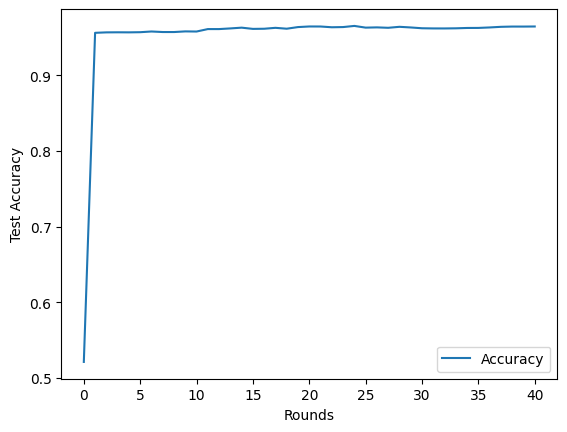

In [9]:
loss_values = None
NUM
figures(acc_values, loss_values)

In [5]:
acc_values = [0.5211841464042664, 0.9560964107513428, 0.9566927552223206, 0.956794261932373, 0.9567181468009949, 0.9569211602210999, 0.9578601717948914, 0.9571495652198792, 0.957136869430542, 0.9579870104789734, 0.9578093886375427, 0.9610450863838196, 0.9610450863838196, 0.9619206190109253, 0.962922990322113, 0.9612988233566284, 0.9614891409873962, 0.9626946449279785, 0.9615399241447449, 0.9636970162391663, 0.9644837379455566, 0.9644457101821899, 0.9634559750556946, 0.9637097120285034, 0.9652197360992432, 0.9629610776901245, 0.9632909893989563, 0.9627453684806824, 0.9640396237373352, 0.9631894826889038, 0.9621363282203674, 0.9619079232215881, 0.9618825316429138, 0.9620601534843445, 0.9625169634819031, 0.9625804424285889, 0.963202178478241, 0.964026927947998, 0.964369535446167, 0.9643568396568298, 0.9644710421562195]

[0.11590077728033066, 0.936072587966919, 0.942799985408783, 0.9460256695747375, 0.9436279535293579, 0.9463878870010376, 0.9458186626434326, 0.9480611085891724, 0.9474229216575623, 0.9498205780982971, 0.9532532691955566, 0.9503898620605469, 0.9528220295906067, 0.9546160101890564, 0.9528048038482666, 0.9522528052330017, 0.9540295600891113, 0.950493335723877, 0.9531843066215515, 0.9518043398857117, 0.9490788578987122]


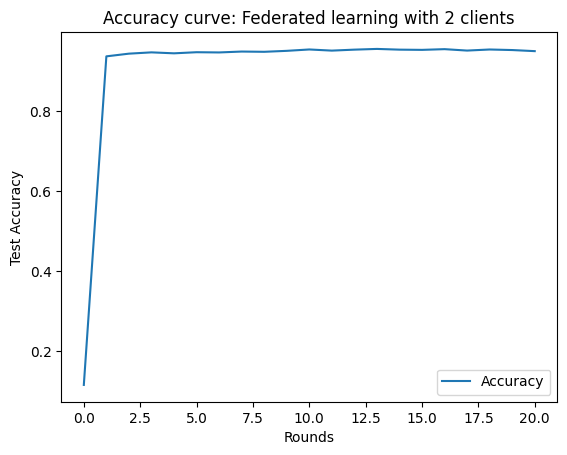

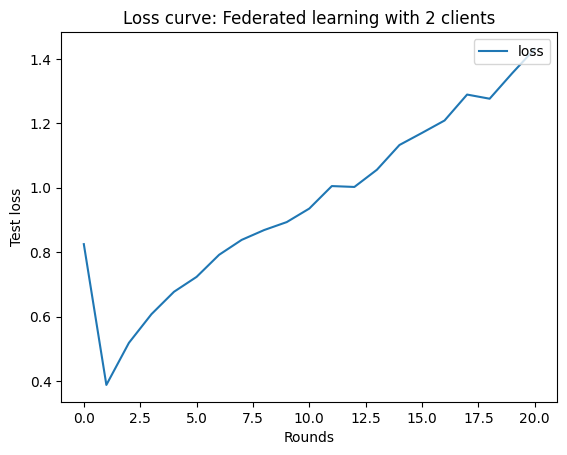

In [ ]:
accuracy3 = history.metrics_centralized['accuracy']
acc_values3 = [item[1] for item in accuracy3]
loss3 = history.metrics_centralized['loss']
loss_values3 = [item[1] for item in loss3]
print(acc_values3)
figures(acc_values3, loss_values3)


In [ ]:
var2 = history.metrics_centralized['Centralised report']
print(type(var2))
for i in var2:
  for pair in i:
    print(pair)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<class 'list'>
0
              precision    recall  f1-score   support

           0    0.09419   0.58381   0.16220      6771
           1    0.82390   0.25749   0.39236     51201

    accuracy                        0.29561     57972
   macro avg    0.45904   0.42065   0.27728     57972
weighted avg    0.73867   0.29561   0.36548     57972

1
              precision    recall  f1-score   support

           0    0.91061   0.35357   0.50936      6771
           1    0.92091   0.99541   0.95671     51201

    accuracy                        0.92044     57972
   macro avg    0.91576   0.67449   0.73304     57972
weighted avg    0.91971   0.92044   0.90446     57972

2
              precision    recall  f1-score   support

           0    0.90680   0.37218   0.52775      6771
           1    0.92298   0.99494   0.95761     51201

    accuracy                        0.92220     57972
   macro avg    0.91489   0.68356   0.74268     57972
weighted avg    0.92109   0.92220   0.90740     57972